#### Explainability of CNN using LIME


In [1]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'feature/explainability-timing'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy spacy lime
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive
    drive.mount('/content/drive')

Cloning into 'spam-detection'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 405 (delta 37), reused 48 (delta 23), pack-reused 331 (from 1)
Receiving objects: 100% (405/405), 4.45 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Branch 'feature/cnn-lime-2' set up to track remote branch 'feature/cnn-lime-2' from 'origin'.
Switched to a new branch 'feature/cnn-lime-2'
total 68
drwxr-xr-x 11 root root 4096 Aug 10 10:06 .
drwxr-xr-x  1 root root 4096 Aug 10 10:06 ..
-rw-r--r--  1 root root  584 Aug 10 10:06 docker-compose.yml
-rw-r--r--  1 root root  879 Aug 10 10:06 Dockerfile
-rw-r--r--  1 root root   92 Aug 10 10:06 .dockerignore
drwxr-xr-x  2 root root 4096 Aug 10 10:06 docs
drwxr-xr-x  2 root root 4096 Aug 10 10:06 explainability
drwxr-xr-x  8 root root 4096 Aug 10 10:06 .git
-rw-r--r--  1 root root   38 Aug 10 10:06 .gitignore
drwxr-xr-x  2 root root 4096 Aug 10 10

In [2]:
import torch
import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

'/content/drive/MyDrive/Projects/spam-detection-data'

In [3]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [5]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [6]:
from models.cnn import SpamCNN

# Load the trained CNN model
model_path = DATA_PATH + '/trained-models/spam_cnn_final.pt'
cnn_model = SpamCNN(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                    pretrained_embeddings=pretrained_embeddings)
cnn_model.load(model_path, map_location=device)  # map_location handled in load()
cnn_model = cnn_model
cnn_model.eval()

SpamCNN(
  (embedding): Embedding(25245, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:
samples = (150, 357, 402 , 416, 417, 604)
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"



Explaining easy_ham email: Seeing is believing
Explanation time: 0 days 00:00:29.964946


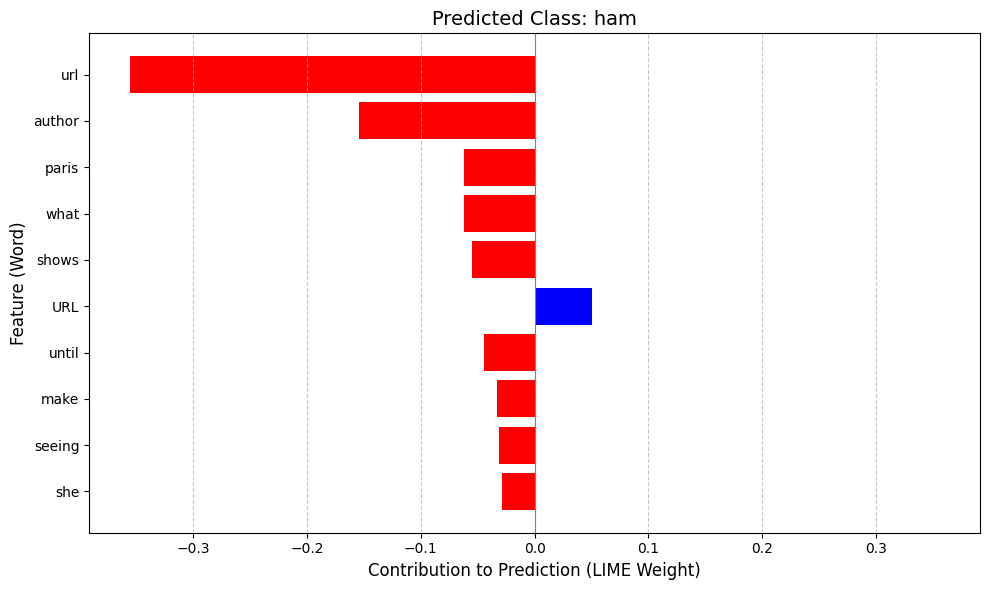


Explaining hard_ham email: Apple Store eNews : November 2002
Explanation time: 0 days 00:00:38.863013


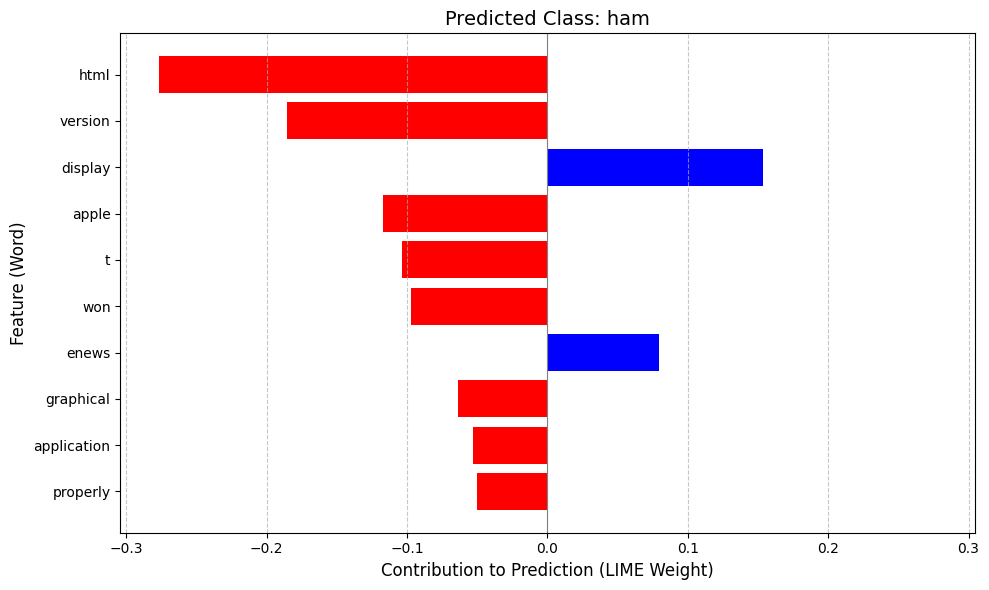


Explaining easy_ham_2 email: RE: [ILUG] NVIDIA and Debian Woody
Explanation time: 0 days 00:04:21.301513


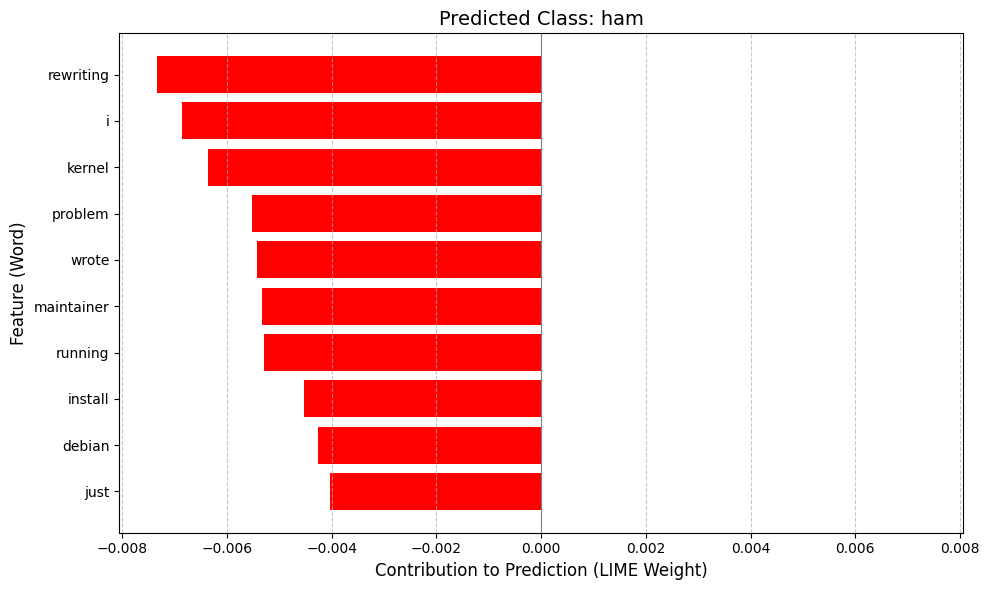


Explaining spam email: The Flight to Safety is Upon Us
Explanation time: 0 days 00:01:17.247759


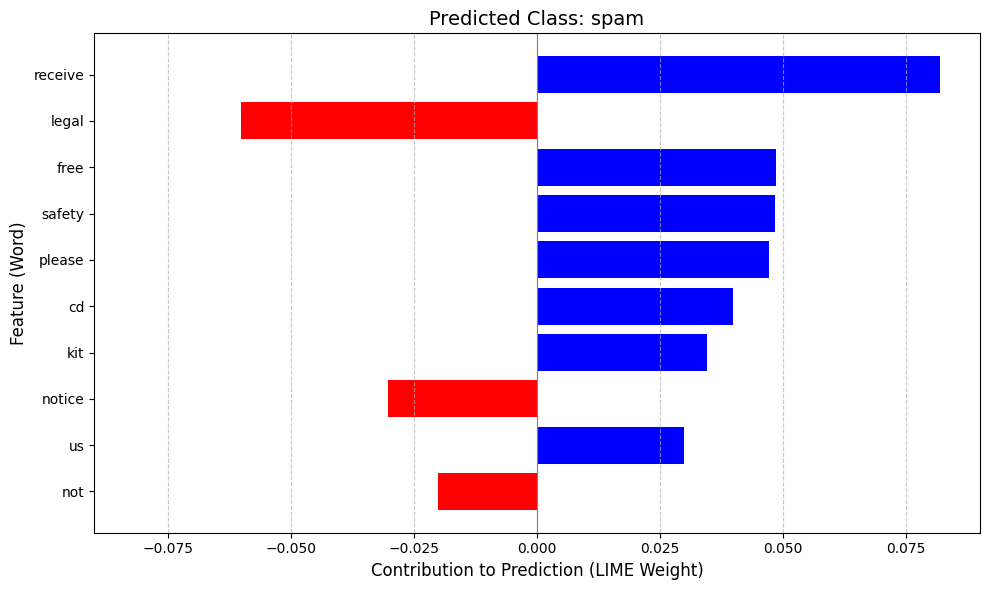


Explaining spam email: Low cost quality conference calls
Explanation time: 0 days 00:00:36.918714


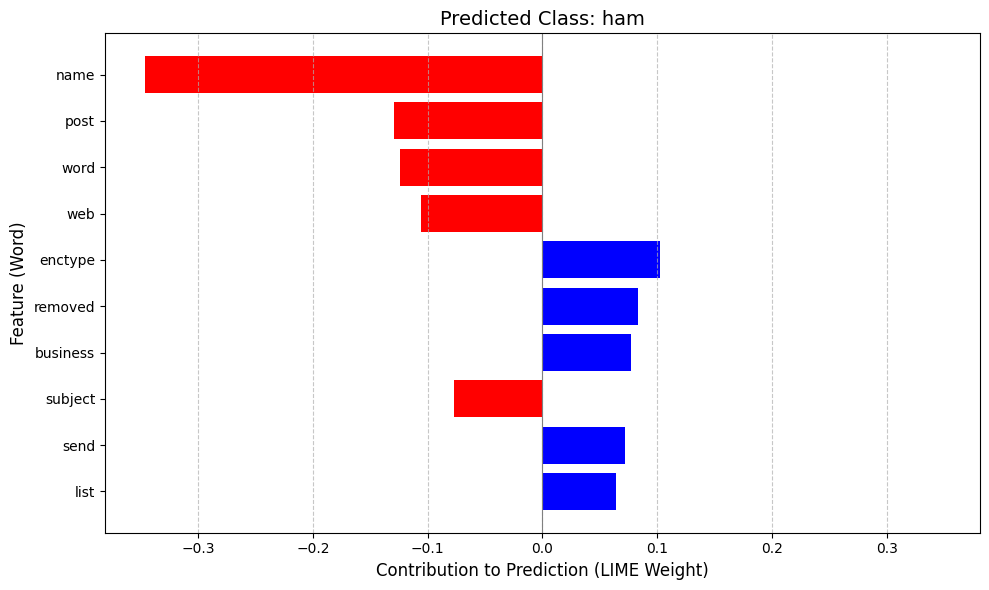


Explaining spam_2 email: Cannabis Difference
Explanation time: 0 days 00:20:58.214701


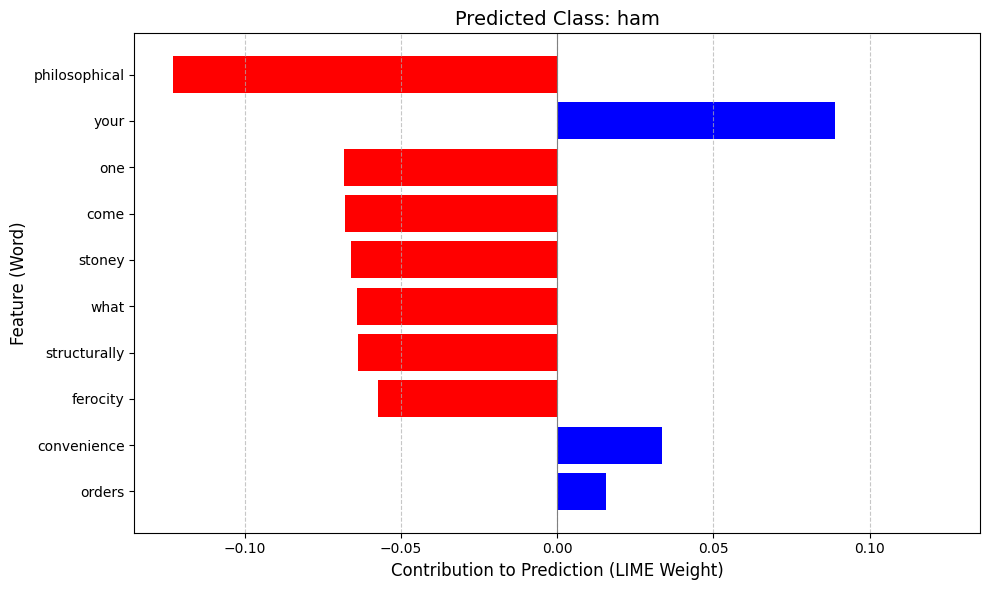

In [8]:
import numpy as np
from explainability.CnnLimeExplainer import get_lime_explanation, plot_lime_explanation

class_names = ['ham', 'spam']
explanations = []
explanation_times = []
for i in samples:
    print(f"\nExplaining {test_df['source'].iloc[i]} email: {test_df['subject'].iloc[i]}")
    start_time = pd.Timestamp.now()
    explanation = get_lime_explanation(
        cnn_model,
        test_df['text'].iloc[i],
        word2idx,
        idx2word,
        num_samples=5000,
        alpha=0.01
    )
    end_time = pd.Timestamp.now()
    explanation_times.append((end_time - start_time).total_seconds())
    explanations.append({
        'index': i,
        'label': test_df['label'].iloc[i],
        'text': test_df['text'].iloc[i],
        'explanation': explanation,
        'predicted_class': class_names[np.argmax(explanation.predict_proba)],
        'subject': test_df['subject'].iloc[i],
        'source': test_df['source'].iloc[i]
    })
    # print("Features contributing to prediction:")
    # pred_class = np.argmax(explanation.predict_proba)
    # print(f"Predicted Class: {class_names[pred_class]}")
    # for feature, weight in explanation.as_list():
    #     print(f"  - {feature}: {weight:.4f}")
    print(f"Explanation time: {end_time - start_time}")
    plot_lime_explanation(explanation.as_list(), f"Predicted Class: {class_names[np.argmax(explanation.predict_proba)]}")

In [ ]:
# create explanation time data frame
explanation_time_df = pd.DataFrame(explanation_times)
explanation_time_df.describe()

In [ ]:
explanations_df = pd.DataFrame(explanations)
explanations_df.set_index('index', inplace=True)
explanations_df

### Evaluation of LIME Explanations using Quality Metrics

Let's evaluate the LIME explanations using several quality metrics:

1. **AUC-Del** (Area Under the Deletion Curve): Measures how model predictions change when removing the most important features first. Lower is better.
2. **AUC-Ins** (Area Under the Insertion Curve): Measures how model predictions change when adding the most important features first. Higher is better.
3. **Comprehensiveness**: Measures prediction change when removing top-k features. Higher values indicate more impact.
4. **Jaccard Stability**: Measures consistency of explanations across similar inputs (higher is better).

These metrics help us quantify the quality of our explanations beyond visual inspection.


Computing metrics for sample 150: Seeing is believing
Plotting deletion and insertion curves for sample 150


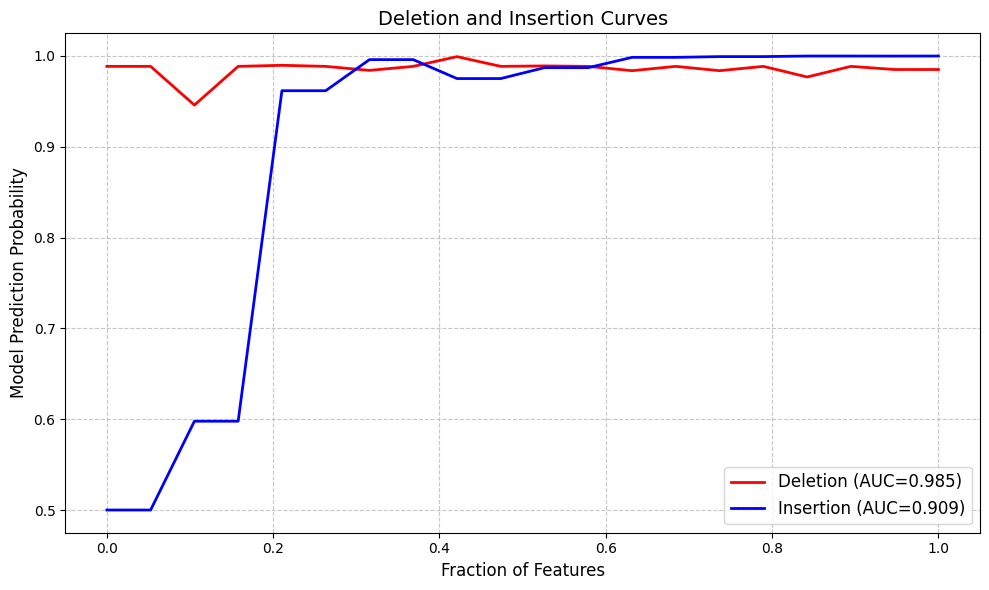


Computing metrics for sample 357: Apple Store eNews : November 2002
Plotting deletion and insertion curves for sample 357


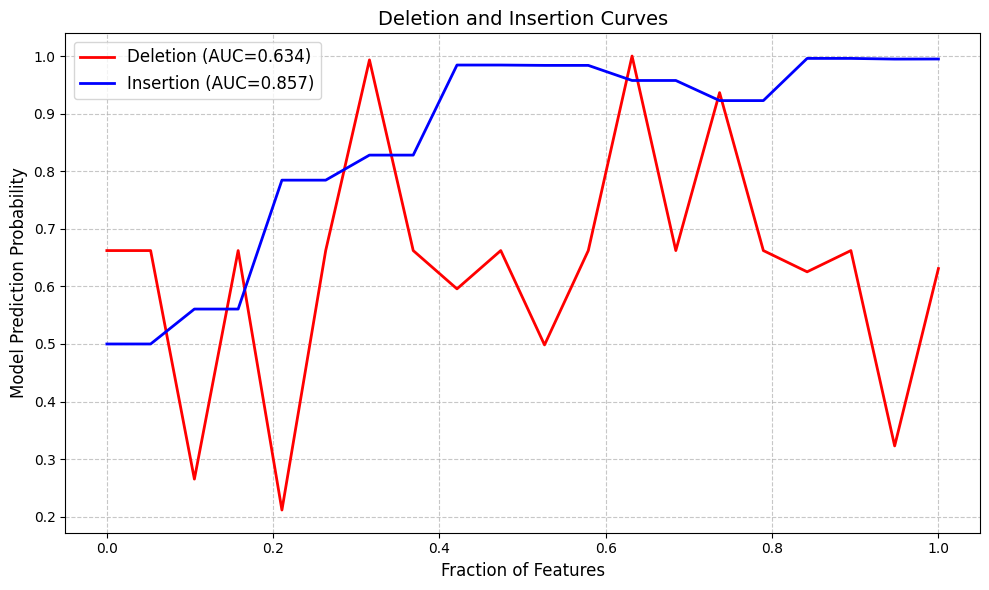


Computing metrics for sample 402: RE: [ILUG] NVIDIA and Debian Woody
Plotting deletion and insertion curves for sample 402


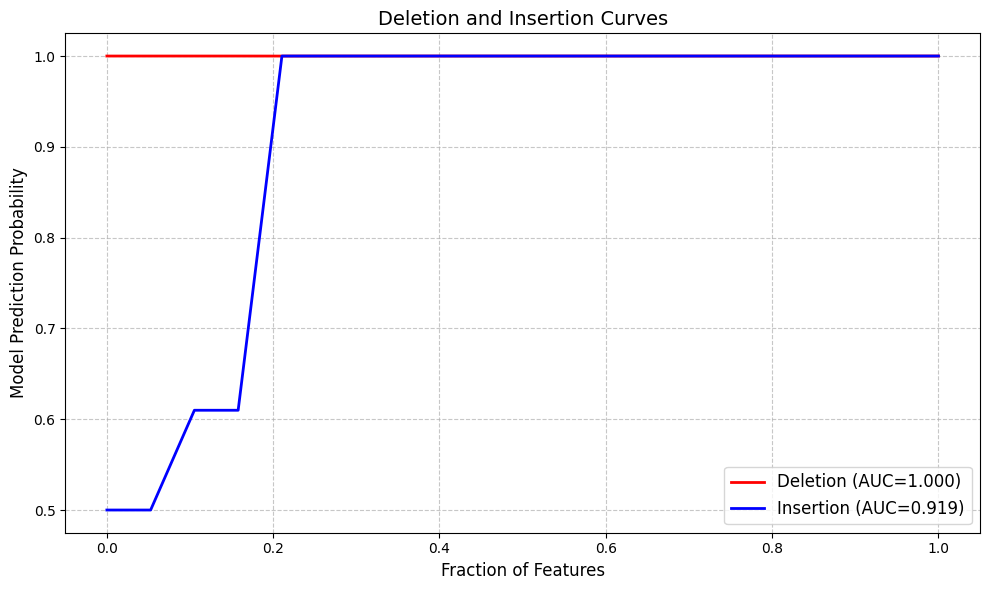


Computing metrics for sample 416: The Flight to Safety is Upon Us
Plotting deletion and insertion curves for sample 416


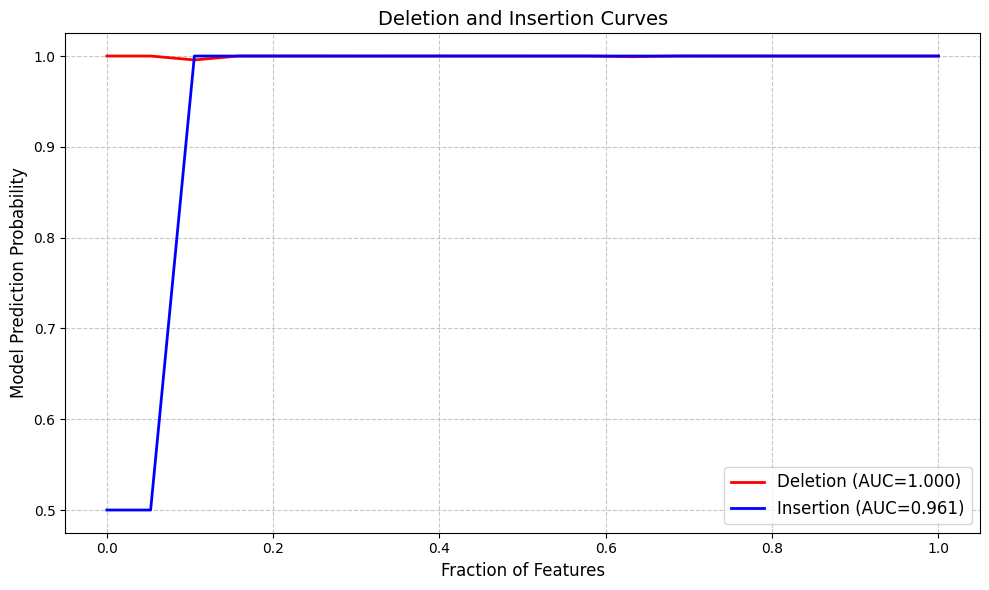


Computing metrics for sample 417: Low cost quality conference calls
Plotting deletion and insertion curves for sample 417


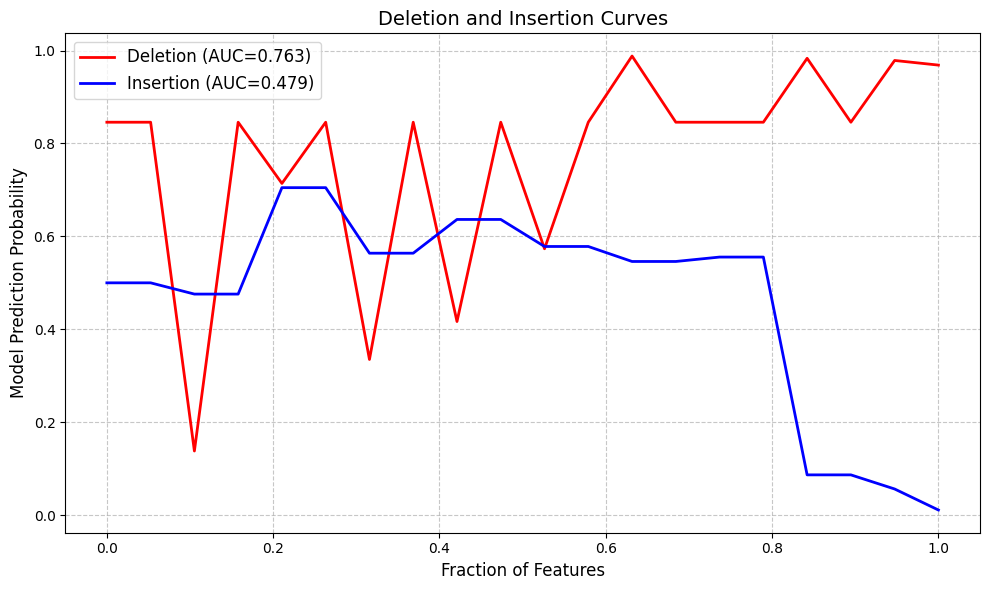


Computing metrics for sample 604: Cannabis Difference
Plotting deletion and insertion curves for sample 604


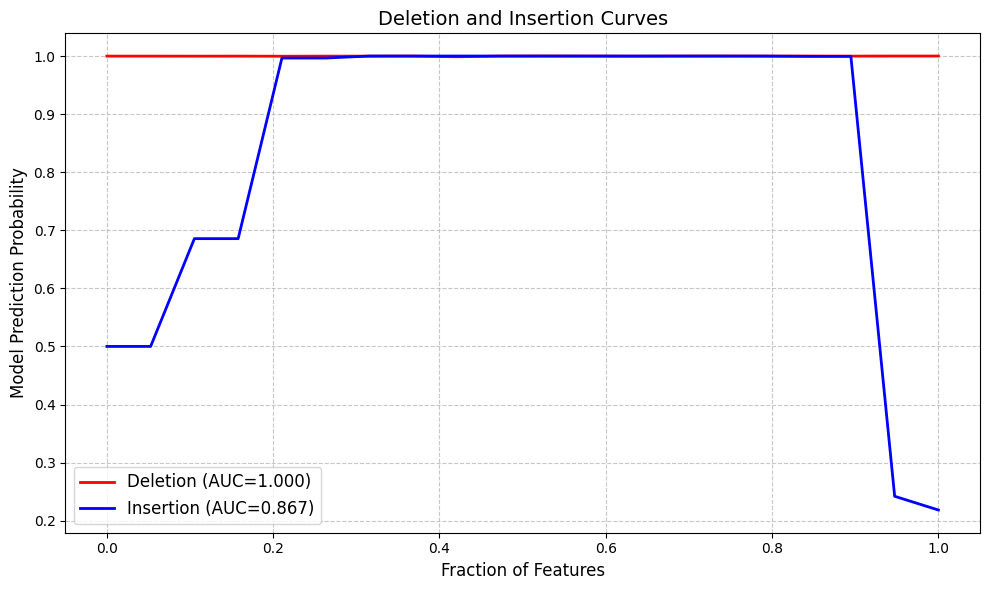

,Subject,AUC-Del,AUC-Ins,Comprehensiveness,Jaccard Stability
Sample,,,,,
150,Seeing is believing,0.985218,0.909417,0.165192,0.587302
357,Apple Store eNews : November 2002,0.634500,0.856642,0.633358,0.408730
402,RE: [ILUG] NVIDIA and Debian Woody,0.999998,0.919460,0.000041,0.134259
416,The Flight to Safety is Upon Us,0.999725,0.960526,0.004049,0.398810
417,Low cost quality conference calls,0.762706,0.479276,0.814170,0.408730
604,Cannabis Difference,0.999797,0.866537,0.295093,0.037037


In [9]:
from explainability.CnnLimeExplainer import (
    compute_auc_deletion, compute_auc_insertion, compute_comprehensiveness,
    compute_jaccard_stability, plot_deletion_insertion_curves, plot_metrics_across_samples,
    CnnLimeExplainer, get_lime_explanation
)
# Create the wrapper for model predictions
explainer_wrapper = CnnLimeExplainer(
    cnn_model,
    word2idx,
    idx2word,
    str(device)
)

# Let's calculate metrics for each sample and store them
metrics_results = []

for index, sample in explanations_df.iterrows():
    print(f"\nComputing metrics for sample {index}: {sample['subject']}")

    explanation = sample['explanation']
    # Text to explain
    text = sample['text']

    # Calculate metrics
    start_time = pd.Timestamp.now()
    auc_del = compute_auc_deletion(explainer_wrapper, explanation, text)
    auc_del_time = (pd.Timestamp.now() - start_time).total_seconds()
    auc_ins_start_time = pd.Timestamp.now()
    auc_ins = compute_auc_insertion(explainer_wrapper, explanation, text)
    auc_ins_time = (pd.Timestamp.now() - auc_ins_start_time).total_seconds()
    comprehens_start_time = pd.Timestamp.now()
    comprehensiveness = compute_comprehensiveness(explainer_wrapper, explanation, text, k=5)
    comprehensiveness_time = (pd.Timestamp.now() - comprehens_start_time).total_seconds()

    # For Jaccard stability, we need similar inputs
    # For text, this is tricky - we'll use a simple approach of taking the current sample
    # and creating variations by removing random words
    # This is a very simplistic approach - in practice, you might want to use
    # techniques like synonym replacement, word dropout, etc.

    # Create slightly modified versions of the text
    import random
    random.seed(42)  # For reproducibility
    tokens = text.split()
    similar_texts = [text]  # Include the original text

    stability_start_time = pd.Timestamp.now()
    # Create 3 variations by removing 10% of words randomly
    for _ in range(3):
        num_to_remove = max(1, int(len(tokens) * 0.1))
        indices_to_remove = random.sample(range(len(tokens)), num_to_remove)
        modified_tokens = [tokens[i] for i in range(len(tokens)) if i not in indices_to_remove]
        similar_texts.append(' '.join(modified_tokens))

    stability = compute_jaccard_stability(
        cnn_model,
        similar_texts,
        word2idx,
        idx2word,
        num_features=5
    )
    end_time = pd.Timestamp.now()
    stability_time = (end_time - stability_start_time).total_seconds()
    print(f"Metrics computed in {(end_time - start_time).total_seconds():.2f} seconds")

    metrics_results.append({
        'Sample': index,
        'Subject': sample['subject'],
        'AUC-Del': auc_del,
        'AUC-Ins': auc_ins,
        'Comprehensiveness': comprehensiveness,
        'Jaccard Stability': stability,
        'AUC-Del Time (s)': auc_del_time,
        'AUC-Ins Time (s)': auc_ins_time,
        'Comprehensiveness Time (s)': comprehensiveness_time,
        'Stability Time (s)': stability_time,
        'Metric Computation Time (s)': (end_time - start_time).total_seconds()
    })

    # Plot deletion and insertion curves for this sample
    print(f"Plotting deletion and insertion curves for sample {i}")
    plot_deletion_insertion_curves(explainer_wrapper, explanation, text)

# Create a DataFrame from the metrics results
metrics_df = pd.DataFrame(metrics_results)
metrics_df.set_index('Sample', inplace=True)
metrics_df

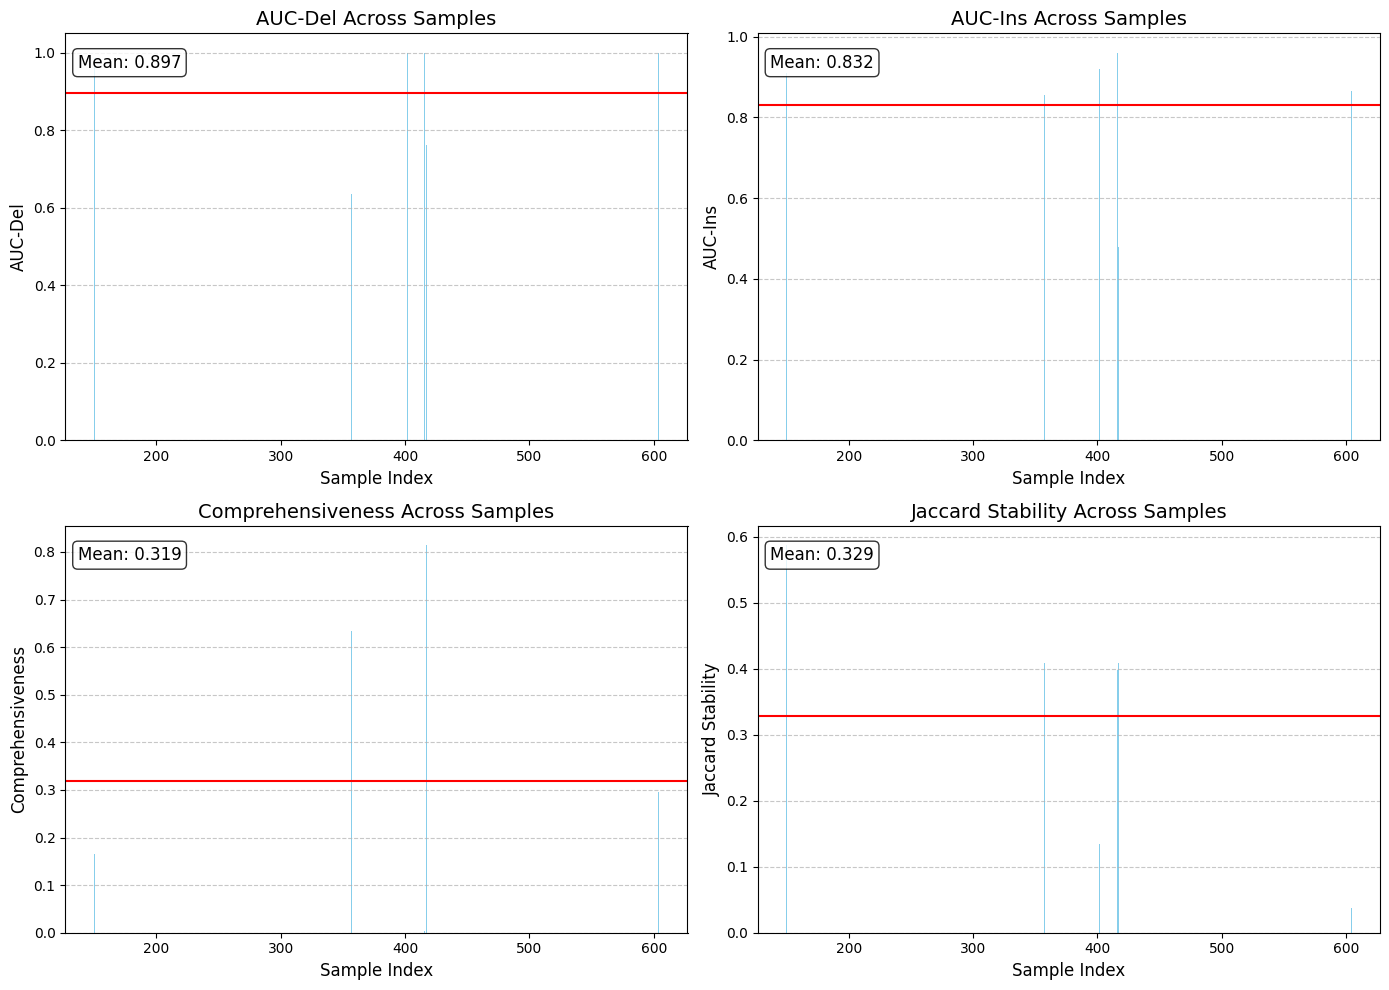

Summary Statistics for Explanation Quality Metrics:
        AUC-Del   AUC-Ins  Comprehensiveness  Jaccard Stability
count  6.000000  6.000000           6.000000           6.000000
mean   0.896991  0.831976           0.318651           0.329145
std    0.159030  0.176848           0.337393           0.203702
min    0.634500  0.479276           0.000041           0.037037
25%    0.818334  0.859116           0.044335           0.200397
50%    0.992472  0.887977           0.230143           0.403770
75%    0.999779  0.916949           0.548792           0.408730
max    0.999998  0.960526           0.814170           0.587302


In [10]:
# Visualize metrics across samples
plot_metrics_across_samples(metrics_df)

# Summary statistics
print("Summary Statistics for Explanation Quality Metrics:")
print(metrics_df.describe())

### Interpretation of Explanation Quality Metrics

Let's interpret what these metrics tell us about our explanations:

#### AUC-Del (Area Under the Deletion Curve)
- Lower is better: It means when we delete important features first, the model's confidence drops quickly
- This indicates that LIME correctly identified the most important features

#### AUC-Ins (Area Under the Insertion Curve)
- Higher is better: It means when we add important features first, the model's confidence rises quickly
- This shows that LIME prioritized the most relevant features

#### Comprehensiveness
- Higher is better: It indicates how much the prediction changes when removing top features
- Large values suggest that the identified features are indeed critical to the prediction

#### Jaccard Stability
- Higher is better: Measures consistency of explanations across similar inputs
- Values close to 1 indicate stable explanations (same features are important for similar texts)
- Low values suggest the explanation method is sensitive to small changes in the input

These metrics help quantify the quality of explanations and can be used to compare different explainability methods.